# How touristic the Greek Islands are?

First we gather the data by scraping the following website that lists the major inhabited islands in Greece 'https://simple.wikipedia.org/wiki/List_of_Greek_islands'. Greece has a large number of islands, with estimates ranging from somewhere around 1,200 to 6,000, depending on the minimum size to take into account. The number of inhabited islands is variously cited as between 166 and 227. However for purposed of this analysis the focus is on the major 40 islands that are the main touristic destinations since smaller islands are not in scope.

## Step 1 - Data Collection:
Source the data from the web

In [1]:
import requests
import lxml.html as lh
import pandas as pd

url='https://simple.wikipedia.org/wiki/List_of_Greek_islands'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

#Create empty list
col=[]
i=0

#Add the headers
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name.rstrip(),[]))

In [2]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        
        #print(f'the data is: {data}')
        #print(f'the index i is: {i} and the index j is: {j}')
        #Append the data to the empty list of the i'th column
        col[i][1].append(data.rstrip())
        #print(f'the tuple is: {col}')
        #Increment i for the next column
        i+=1

In [3]:
#Assign the array to a dictionary and from there to a pandas data frame
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
df.shape

(40, 3)


## Step 2 - Data Manipulation:

With the data sored in a data frame we then perform a number of processing steps in order to make the data fit for our analysis:
1. we drop the Rank since it is not necessary for our analysis
2. we convert the area from string to int. To do that we first need to get rid of the '.' which make the conversion to fail and finally
3. we create a weight column by normalizing the size of the islands based on the size of the largest island. This is important since larger islands are expected to have more hotels, bars, etc.

In [4]:
df.drop('Rank by size',axis = 1, inplace = True)

#Convert the area from string to int in order to be able to perform calculations on it
df["Area (km²)"]=df["Area (km²)"].str.replace('.', '').astype(int)

#Normalize the since on the last column
maxArea = maxArea = df.max()['Area (km²)']
df['NormalSize'] = df.apply(lambda row: row['Area (km²)']/maxArea, axis=1)
df.head()

,Island name,Area (km²),NormalSize
0,Crete,8336,1.000000
1,Euboea,3655,0.438460
2,Lesbos,1630,0.195537
3,Rhodes,1398,0.167706
4,Chios,842,0.101008


## Step 3: Foursquare API

Next we will gather information from FourSquare on those islands.

In [5]:
CLIENT_ID = '0M54ZUC1RXUHQCJ01CXK1OSXHYVBUQGJQYHUSUULTELOW4DF' # your Foursquare ID
CLIENT_SECRET = 'CKSLIBZHERBJLSCHPFDGLHGMEYT4S441D1PXAQTVXTV42RNU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [6]:
from pandas.io.json import json_normalize

In [107]:
LIMIT = 1000
radius = 500

def requestFoursquareData(df):
    dataframe = pd.DataFrame()
    for i in range (0,len(df)):
    #for i in range (0,2):
        name = df.iloc[i]['Island name']
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&near={}&limit={}&radius={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        name,
        LIMIT,
        radius)
    
        results = requests.get(url).json()
    
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
    
        temp = json_normalize(venues)
        temp['Name'] = name
        dataframe = dataframe.append(temp, ignore_index = True, sort=True)
    return dataframe
#     print(dataframe.shape, temp.shape)

dataframe = requestFoursquareData(df)
dataframe.shape

(6347, 19)

By inspecting the data below it was identifies that for a few islands the country is not GR therefore Foursquare API has not returned the correct results for the venues. For those islands we either need to find a different name with which they are represented in the Foursquare API or exclude them from our analysis for now

In [108]:
temp = dataframe.groupby(['Name', 'location.cc']).size().unstack(fill_value=0)
temp.loc[temp['GR'] == 0]

location.cc,GR,TR
Name,,


After a few trial with the API we've found the following replacements:
- Crete --> Creta
- Ithaca -->Ithaka
- Ios --> Íos

We've found that by manually inserting the latitude and longitude in the Foursquare API and observe some of the value returned.
Therefore we need to amend the dataframe with the island names and make the request again:

In [15]:
#Define a function to replace values in the island list
def replace_Island_Name(name, newName,islandList):
    index = islandList[islandList['Island name']==name].index.values.astype(int)[0]
    islandList.at[index,'Island name'] = newName

#Replace the three values
replace_Island_Name('Crete', 'Creta',df)
replace_Island_Name('Ithaca', 'Ithaka',df)
replace_Island_Name('Ios', 'Íos',df)

IndexError: index 0 is out of bounds for axis 0 with size 0

After replacing the values as mentioned above we call the Foursquare API once again. Following that we review the results once again we find that there are no results outside of Greece

In [17]:
dataframe = requestFoursquareData(df)

In [325]:
temp = dataframe.groupby(['Name', 'location.cc']).size().unstack(fill_value=0)
temp.loc[temp['GR'] == 0]

location.cc,GR,TR
Name,,


We then select only the category column and the columns that have the island name and the location country. The latter is selected because there is one row that has a country other than GR which needs to be removed. Some preprocessing is required to extract the category from the json object

In [326]:
temp = dataframe[['Name', 'categories', 'location.cc']]
temp = temp.rename(index=str, columns={'Name':'IslandName','categories':'Categories', 'location.cc':'Country'})

#exclude the non GR rows
temp = temp[temp.Country == 'GR']
#Drop the country column since it is no longer needed and get the category values from the json in the category
temp = temp[['IslandName','Categories']]

In [327]:
# Define a function to retrieve the category of the venue
def returnCategory(obj_list):
    category = ''
    if len(obj_list) > 0:
        category = obj_list[0]['name']
    return (category)

In [328]:
#Create a new column with the category and drop the original column

temp['Category'] = temp.Categories.apply(returnCategory)

temp = temp[['IslandName','Category']]

In [329]:
temp.head()

,IslandName,Category
0,Creta,Port
1,Creta,Boat or Ferry
2,Creta,Boat or Ferry
3,Creta,Travel Agency
4,Creta,Boat or Ferry


With the category in place we review the unique values with the ultimate goal to create our feature list for each island which will be wether they have port/airport, the number of hotels and the number of bars/coffee shops and restaurants they have.

In [330]:
temp.Category.unique()

array(['Port', 'Boat or Ferry', 'Travel Agency', 'Sports Club',
       'Snack Place', 'Tourist Information Center', 'Fish Taverna',
       'Seafood Restaurant', 'Government Building', 'Theme Park',
       'Gas Station', 'Music Venue', '', 'Rental Car Location',
       'Bus Station', 'Cruise', 'Gym / Fitness Center', 'Nail Salon',
       'Bank', 'Bookstore', 'Theater', 'Other Nightlife', 'Hobby Shop',
       'Public Art', 'Historic Site', 'Greek Restaurant', 'Park',
       'Coffee Shop', 'Mediterranean Restaurant',
       'College Administrative Building', 'Pizza Place', 'Military Base',
       'Souvlaki Shop', 'Playground', 'Fast Food Restaurant', 'Rock Club',
       'Club House', 'Building', 'Bowling Alley', 'Social Club',
       'Pet Store', 'Convenience Store', 'Newsstand', 'Jewelry Store',
       'Electronics Store', 'Hardware Store', 'IT Services',
       'Warehouse Store', 'Mobile Phone Shop', 'Health & Beauty Service',
       'Café', 'Furniture / Home Store', 'Hotel', 'Bed & Bre

After carefully reviewing the different categories in the Foursquare data we decided that the following belong to accomodation and food entertainment:
- **Accomodation:** 'Hotel','Bed & Breakfast','Vacation Rental','Resort','Residential Building (Apartment / Condo)','Spa','Hotel Bar','Hostel','Motel'
- **Food Entertainment:** 'Greek Restaurant','CafÃ©','Bar','Bakery','Cocktail Bar','Dessert Shop','Coffee Shop','Nightclub','Souvlaki Shop','Pizza Place','Taverna','Fast Food Restaurant','Restaurant','Grocery Store','Snack Place','Seafood Restaurant','Italian Restaurant','Kafenio','Mediterranean Restaurant','Meze Restaurant','Fish Taverna','Burger Joint','Breakfast Spot','Sandwich Place','Candy Store','Creperie','Food & Drink Shop','Frozen Yogurt Shop','Ouzeri','Bistro','Deli / Bodega','Internet Cafe','Food','Modern Greek Restaurant','Bougatsa Shop','Donut Shop','Pub','Steakhouse','Grilled Meat Restaurant','Cafeteria','Chinese Restaurant','Cupcake Shop','Falafel Restaurant','Juice Bar','Cretan Restaurant','Diner','Sushi Restaurant','Karaoke Bar','Fish & Chips Shop','Paella Restaurant','Piano Bar','Turkish Restaurant'

In [331]:
def isAccomodation(category):
    AccList = ['Hotel','Bed & Breakfast','Vacation Rental','Resort','Residential Building (Apartment / Condo)','Spa','Hotel Bar','Hostel','Motel']
    if AccList.count(category):
        return 1
    else:
        return 0
def isFoodEntertainment(category):
    FooEntList = ['Greek Restaurant','Café','Bar','Bakery','Cocktail Bar','Dessert Shop','Coffee Shop','Nightclub','Souvlaki Shop','Pizza Place','Taverna','Fast Food Restaurant','Restaurant','Grocery Store','Snack Place','Seafood Restaurant','Italian Restaurant','Kafenio','Mediterranean Restaurant','Meze Restaurant','Fish Taverna','Burger Joint','Breakfast Spot','Sandwich Place','Candy Store','Creperie','Food & Drink Shop','Frozen Yogurt Shop','Ouzeri','Bistro','Deli / Bodega','Internet Cafe','Food','Modern Greek Restaurant','Bougatsa Shop','Donut Shop','Pub','Steakhouse','Grilled Meat Restaurant','Cafeteria','Chinese Restaurant','Cupcake Shop','Falafel Restaurant','Juice Bar','Cretan Restaurant','Diner','Sushi Restaurant','Karaoke Bar','Fish & Chips Shop','Paella Restaurant','Piano Bar','Turkish Restaurant']
    if FooEntList.count(category):
        return 1
    else:
        return 0

temp['isAccomodation'] = temp.Category.apply(isAccomodation)
temp['isFoodEntertainment'] = temp.Category.apply(isFoodEntertainment)

In [332]:
sum_df = temp.groupby(['IslandName']).agg({'isAccomodation':'sum','isFoodEntertainment':'sum'})

In [333]:
sum_df.head()

,isAccomodation,isFoodEntertainment
IslandName,,
Aegina,7,74
Alonnisos,39,85
Amorgos,19,42
Andros,16,67
Astypalaia,33,67


We then need to visualize the data to find out how they are distributed in the two dimentional space

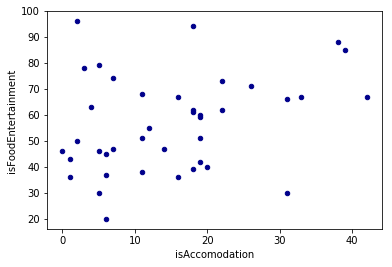

In [334]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline

sum_df.plot.scatter(x='isAccomodation',y='isFoodEntertainment',c='DarkBlue')